In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pdb

In [2]:
import pickle

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。  
ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。
$$
g(z) = \frac{1}{1 + e^{-x}}
$$
線形回帰の仮定関数は次の式でした。  
$$
h_{\theta}(x) = \theta^{T}\cdot x
$$
まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。  
$$
h_{\theta}(x) = \frac{1}{1 + e^{-\theta^{T}\cdot x}}
$$

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。  
以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。
$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\
$$
$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\
$$
$$
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$$

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。  
仮定関数 $ h_{\theta}(x) $ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。  
なお、この数式には正則化項が含まれています。
$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$

In [155]:
class ScratchLogisticRegression():
    
    def __init__(self, num_iter=10000, alpha=0.001, l2=3, bias=None, verbose=None):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.alpha = alpha
        self.l2 = l2
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
        self.X = None
        self.y = None
        self.m = None
        self.theta = None
        self.h = None
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.X = X
        self.y = y.reshape(-1, 1)
        self.m = len(X)
        if self.bias:
            self.X = np.insert(arr=self.X, obj=0, values=1, axis=1)
            if X_val is not None:
                X_val = np.insert(arr=X_val, obj=0, values=1, axis=1)
        self.theta = np.random.randn(self.X.shape[1], 1)
        
        for i in range(self.iter):
            self.h = self.predict_proba(self.X)
            self.theta -= self.alpha * self._gradient_descent()
            self.loss[i] = self._crossentropyloss(self.predict_proba(self.X), self.y)
            if X_val is not None:
                self.val_loss[i] = self._crossentropyloss(self.predict_proba(X_val), y_val)
        with open('./theta.pickle', 'wb') as f:
            pickle.dump(self.theta, f)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.loss)
        

    def predict(self, X_test, threshold=0.5):
        if self.bias:
            X_test = np.insert(arr=X_test, obj=0, values=1, axis=1)
        h = self.predict_proba(X_test)
        return np.where(h>threshold, 1, 0)

    def predict_proba(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.theta)))
    
    def _gradient_descent(self):
        return (np.dot(self.X.T, self.h-self.y) + self.l2*self.theta) / self.m
    
    def _crossentropyloss(self, h, y):
        start = 1 if self.bias else 0
        reg = self.l2 / (2*self.m) * np.sum(self.theta[start:]**2)
        return np.sum(-y*np.log(h) - (1-y)*np.log(1-h))/self.m + reg

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

## 【問題7】決定領域の可視化
決定領域を可視化してください。

## 【問題8】重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。  
pickleモジュールやNumPyのnp.savezを利用します。

In [169]:
data = load_iris()
df = pd.DataFrame(np.hstack((data.data, data.target[:,np.newaxis])),
                  columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [170]:
X = df.loc[df.target.isin([1, 2]), ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
# versicolor: 0, virginica: 1とする
y = df.loc[df.target.isin([1, 2]), 'target'].values - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [171]:
slr = ScratchLogisticRegression(bias=False)
slr.fit(X_train, y_train, X_test, y_test)

In [172]:
print(slr.theta)

[[-0.51904621]
 [-0.88730383]
 [ 1.12843148]
 [ 0.29547663]]


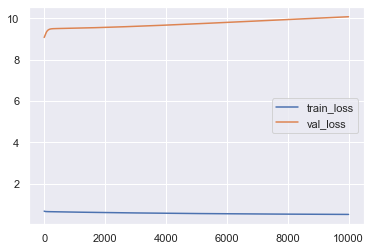

In [173]:
plt.plot(slr.loss, label='train_loss')
plt.plot(slr.val_loss, label='val_loss')
plt.legend();

In [174]:
y_pred = slr.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

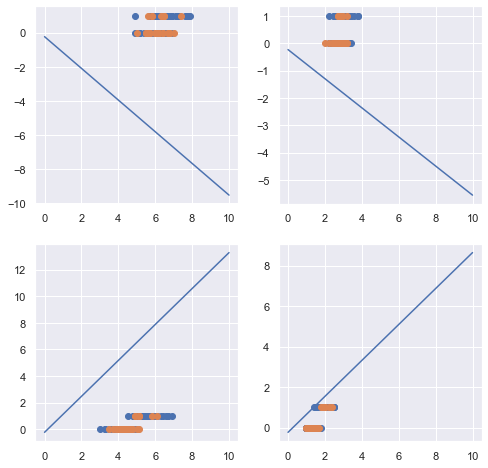

In [105]:
x = np.linspace(0, 10, 100)
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.ravel()
theta = slr.theta.ravel()
ax[0].scatter(X_train[:,0], y_train)
ax[0].scatter(X_test[:,0], y_test)
ax[0].plot(x, theta[1]*x+theta[0])
ax[1].scatter(X_train[:,1], y_train)
ax[1].scatter(X_test[:,1], y_test)
ax[1].plot(x, theta[2]*x+theta[0])
ax[2].scatter(X_train[:,2], y_train)
ax[2].scatter(X_test[:,2], y_test)
ax[2].plot(x, theta[3]*x+theta[0])
ax[3].scatter(X_train[:,3], y_train)
ax[3].scatter(X_test[:,3], y_test)
ax[3].plot(x, theta[4]*x+theta[0])

In [167]:
def plot_3d(X, col1, col2, y):
    a = np.linspace(np.min(X[:,col1])-0.5, np.max(X[:,col1])+0.5, num=10)
    b = np.linspace(np.min(X[:,col2])-0.5, np.max(X[:,col2])+0.5, num=10)
    a, b = np.meshgrid(a, b)
    c = a * slr.theta[col1] + b * slr.theta[col2]

    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(a, b, c, color='blue', alpha=0.2)
    ax.scatter(X[:,col1], X[:,col2], y, c='r')
    #ax.set_xlabel('sepal_length')
    #ax.set_ylabel('sepal_width')
    ax.view_init(elev=10, azim=100);

    ax1 = fig.add_subplot(122, projection='3d')
    ax1.plot_surface(a, b, c, color='blue', alpha=0.2)
    ax1.scatter(X[:,col1], X[:,col2], y, c='r')
    #ax1.set_xlabel('sepal_length')
    #ax1.set_ylabel('sepal_width')
    ax1.view_init(elev=30, azim=160);

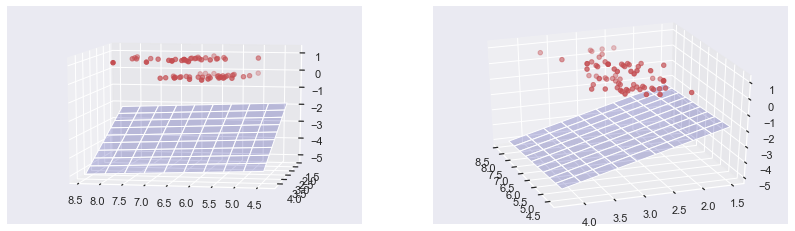

In [168]:
plot_3d(X_train, 0, 1, y_train)

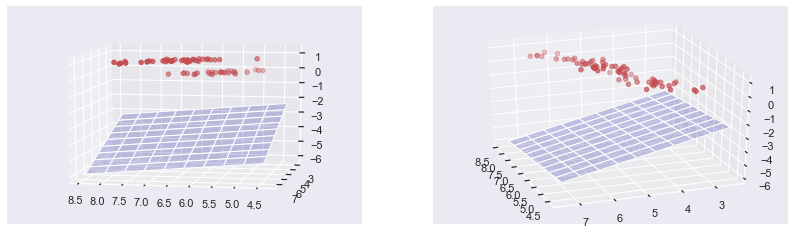

In [108]:
plot_3d(X_train, 0, 2, y_train)

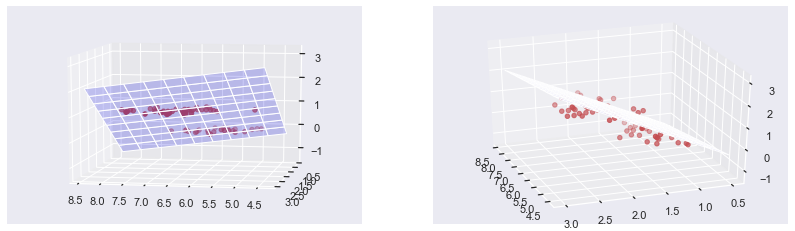

In [109]:
plot_3d(X_train, 0, 3, y_train)

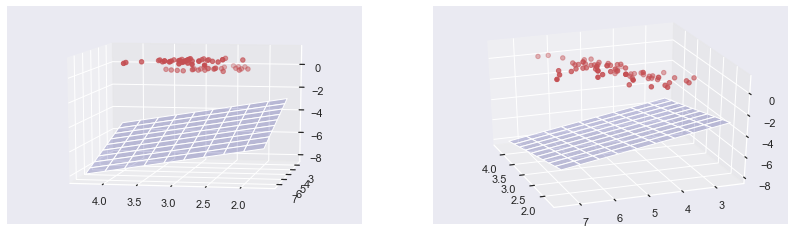

In [110]:
plot_3d(X_train, 1, 2, y_train)

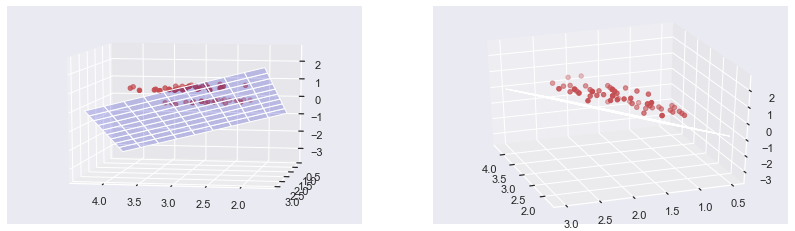

In [111]:
plot_3d(X_train, 1, 3, y_train)

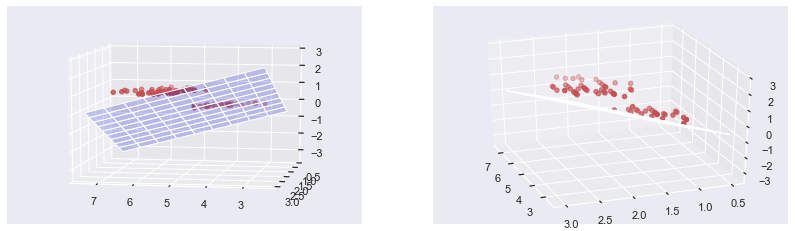

In [112]:
plot_3d(X_train, 2, 3, y_train)

In [113]:
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = np.where(y_pred_lr>0.5, 1, 0)

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [114]:
accuracy_score(y_test, y_pred_lr)

0.9

In [115]:
np.sum(y_pred.ravel() == y_pred_lr) / len(y_pred)

0.8

In [116]:
pd.DataFrame({'scratch':y_pred.ravel(), 'sklearn': y_pred_lr})

,scratch,sklearn
0,1,1
1,0,0
2,0,0
3,1,0
4,0,0
5,1,1
6,1,1
7,1,1
8,1,0
9,0,0


In [117]:
with open('./theta.pickle', 'rb') as f:
    print(pickle.load(f))

[[-0.23249745]
 [-0.93156204]
 [-0.53181108]
 [ 1.35097484]
 [ 0.88723148]]
